# SCC-ICMC-USP - 1st. Semester - 2023
# SCC5948/MAI5024. Data Science - Final Work – **03.** Training and Test

### Prof. PhD. Roseli Aparecida Francelin Romero

### Monitor: Diogo Godoi

Group Number: 12

Students:

1.   Leandro Marcos da Silva (**13702000**)
2.   Vinícius Andreghetti (**9898012**)


## Imports

In [1]:
# Imports
from imblearn.over_sampling import KMeansSMOTE
from pathlib import Path
from pycaret.classification import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from time import time
from utils import split_X_y # utils.py

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
import warnings
import xgboost as xgb
import pycaret


# Ignore Pandas warnings
warnings.filterwarnings("ignore")

# Random state default
RANDOM_STATE = 42

## Functions

In [2]:
def plot_roc_curve(model, fpr, tpr, roc_auc, k,
                   save_figure=False, reports_path=None, file_name=None):
    # Config the plot
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.plot([0, 1], [0, 1], ls='--')
    plt.ylim([-0.01, 1.01])
    plt.xlim([-0.01, 1.01])
    plt.xlabel('False Positive Rate', size=16)
    plt.ylabel('True Positive Rate', size=16)

    linspace = np.linspace(0, 1, 100)

    # Calculate the mean ROC
    int_tpr = [np.interp(linspace, fpr[i], tpr[i]) for i in range(k)]
    mean_tpr = np.mean(int_tpr, axis=0)

    # Plot all ROC curves for each fold and the average ROC curve
    for i in range(k):
        plt.plot(fpr[i], tpr[i], label=f'fold {i + 1}, Area: {roc_auc[i]:.5f}')
    
    plt.plot(linspace, mean_tpr, label=f'Average Curve, Area: {auc(linspace, mean_tpr):.5f} (+/- {np.std(roc_auc)*2:.5f})')

    # Plot the graph
    plt.legend(prop={'size': 16})
    # Save the ROC curve
    plt.savefig(f'{reports_path}images/{file_name}-roc_curve.png')
    plt.show() # Show the plot



def plot_confusion_matrix(y_true, y_pred, class_names, normalized,
                          save_figure=False, reports_path=None, file_name=None):
    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize=normalized)
    # Confusion matrix display
    cm_p = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10,10)) # Plot size
    plt.rc('font', **{'size':14}) # Setting font size 
    cm_p.plot(ax=ax) # Confusion matrix plot show
    
    if save_figure == True: # Save figure
        plt.savefig(f'{reports_path}images/{file_name}-cm.png')
        
    # Return confusion matrix
    return cm



def classification_with_report(model, X, y, k, class_names, save_report=False,
                               reports_path=None, file_name=None, verbose=True):
    # Lists
    fpr, tpr, roc_auc = [], [], []
    original_label, predicted_label, predicted_proba = [], [], []
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(k)
    
    # Time counting
    start = time()
    
    # Train and test the model for each 'k' fold in all the data
    for train_index, test_index in skf.split(X,y):
        model.fit(X.iloc[train_index], y[train_index])
        y_pred_probability = model.predict_proba(X.iloc[test_index])

        # Predict to generate classification report
        y_pred = model.predict(X.iloc[test_index])
        predicted_label.extend(y_pred)
        original_label.extend(y[test_index])

        # Compute micro-average ROC curve and ROC area
        temp_fpr, temp_tpr, _ = roc_curve(y[test_index], y_pred_probability[:,1])
        fpr.append(temp_fpr)
        tpr.append(temp_tpr)
        roc_auc.append(auc(temp_fpr, temp_tpr))
     
    # Total time spent on training
    total_time = time() - start

    if verbose == True: # Show results
        # Results
        print('\t\t\tClassification Report\n\n')
        print(classification_report(original_label, predicted_label, target_names=class_names, digits=5))
        print('Accuracy: ' + str(round(accuracy_score(original_label, predicted_label), 5)))
        print('F1-Score: ' + str(round(f1_score(original_label, predicted_label), 5)))
        print('Precision: ' + str(round(precision_score(original_label, predicted_label), 5)))
        print('Recall: ' + str(round(recall_score(original_label, predicted_label), 5)))
        print('AUC: ' + str(round(np.mean(roc_auc), 5)))
        print('Total Time: ' + str(round(total_time, 5)) + ' seconds')
        print('Confusion Matrix:\n')
        # Plot the ROC curve
        plot_roc_curve(model, fpr, tpr, roc_auc, k)
        # Plot the confusion matrix
        _ = plot_confusion_matrix(original_label, predicted_label, class_names, None)

    if save_report == True: # Save report
        # file_name (without extension)
        with open(reports_path + file_name + '.txt', 'a+') as f:
            f.write(type(model).__name__ + '\n ')
            f.write(str(model))
            f.write('\n\n\n')
            f.write('\t\t\tClassification Report\n\n')
            f.write(classification_report(original_label, predicted_label, target_names=class_names, digits=5))
            f.write('\n\nAccuracy: ' + str(round(accuracy_score(original_label, predicted_label), 5)))
            f.write('\n\nF1-Score: ' + str(round(f1_score(original_label, predicted_label), 5)))
            f.write('\n\nPrecision: ' + str(round(precision_score(original_label, predicted_label), 5)))
            f.write('\n\nRecall: ' + str(round(recall_score(original_label, predicted_label), 5)))
            f.write('\nAUC: ' + str(round(np.mean(roc_auc), 5)))
            f.write('\nTotal Time: ' + str(round(total_time, 5)) + ' seconds\n\n')
            # Save the ROC curve
            plot_roc_curve(model, fpr, tpr, roc_auc, k,
                           save_figure=True, reports_path=reports_path, file_name=file_name)
            # Save the confusion matrix
            _ = plot_confusion_matrix(original_label, predicted_label, class_names, None,
                                      save_figure=True, reports_path=reports_path, file_name=file_name)

    return model # Return trained model



def objective(trial, X, y, k):
    params = { # Hyperparameters that will be optimized
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    }

    # Stratified K-Folds cross-validator
    skf = StratifiedKFold(k)
    scores = np.empty(k) # Save score of each fold

    # Train and validation the model for each 'k' fold
    for idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = lgb.LGBMClassifier(**params) # Start model
        # Train model
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                  early_stopping_rounds=100,
        )

        # Predict the values based on the F1-score
        preds = model.predict(X_val)
        scores[idx] = f1_score(y_val, preds)

    return np.mean(scores)



def report_model(model, X, y, class_names, normalized='true'):
    # Predict to generate report
    y_pred = model.predict(X)

    # Results
    print('\t\t\tClassification Report\n\n')
    print(classification_report(y, y_pred, target_names=class_names, digits=5))

    # Confusion matrix
    print('\nConfusion Matrix:\n')
    cm = plot_confusion_matrix(y, y_pred, class_names, normalized)
    # True Negative (TN)
    tn = cm[0][0]
    # False Negative (FN)
    fn = cm[1][0]
    # True Positive (TP)
    tp = cm[1][1]
    # False Positive (FP)
    fp = cm[0][1]
    # True Positive Rate (TRP)
    tpr = tp / (tp + fn)
    # False Positive Rate (FPR)
    fpr = fp / (fp + tn)
    print(f'True Positive Rate (TPR): {round(tpr, 5)}')
    print(f'False Positive Rate (FPR): {round(fpr, 5)}')


def save_object(obj, file_name):
    with open(f'{file_name}.pkl', 'wb') as f:
        pickle.dump(obj, f) # Save object with .pkl extension


        
def load_object(file_name):
    with open(f'{file_name}.pkl', 'rb') as f:
        loaded_obj = pickle.load(f) # Load object saved as .pkl
    
    return loaded_obj # Return loaded object



def lgb_plot_importance(booster, figsize, **kwargs):    
    # Create figure with size defined
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Bar chart with the importance of features
    return lgb.plot_importance(booster=booster, ax=ax, **kwargs)



def optimize_save_lgb(X, y, n_trials, k, models_path, reports_path, column_set):
    # Optimize LightGBM hyperparameters (selected algorithm)
    study = optuna.create_study(direction="maximize", study_name="lightgbm")
    func = lambda trial: objective(trial, X, y, k)
    # Setting the logging level CRITICAL
    optuna.logging.set_verbosity(optuna.logging.CRITICAL)
    study.optimize(func, n_trials=n_trials, n_jobs=-1)

    # Save the best parameters in a .pkl file
    save_object(study.best_params, f'{models_path}params_lgb_{column_set}')
    
    # Load the best parameters
    best_params = load_object(f'{models_path}params_lgb_{column_set}')
    
    for i in range(3): # Run three times to average the execution time
        # LightGBM (optimized)
        model = lgb.LGBMClassifier(**best_params)
        model = classification_with_report(model, X, y, k, ['Normal', 'Evil Twin'],
                                           save_report=True, reports_path=reports_path,
                                           file_name=f'lgb_{column_set}_optimized', verbose=False)
        
    # Save optimized LightGBM model
    save_object(model, f'{models_path}lgb_{column_set}_optimized')
    # Load optimized LightGBM model
    model = load_object(f'{models_path}lgb_{column_set}_optimized')
    
    # Return the trained model
    return model



def get_df_column_set(df, numeric_columns, column_name):
    # DataFrame with column set
    return df[numeric_columns + list(df.filter(regex=column_name).columns)]

## Main


In [3]:
# General path
path = f'{str(Path.home())}/EvilTwin_detection/'
# Pre-processed data path
preprocessed_data_path = f'{path}data/pre_processed/'
# Path to save the models
models_path = f'{path}/models/'
# Path to save results
reports_path = f'{path}/reports/'

# Load pre-processed training dataset
train_df = pd.read_csv(preprocessed_data_path + 'train_data.csv')
# Load pre-processed test dataset
test_df = pd.read_csv(preprocessed_data_path + 'test_data.csv')

In [4]:
# Split train data into X and y
X_train, y_train = split_X_y(train_df)
# Split test data into X and y
X_test, y_test = split_X_y(test_df)

# Balance train data with SMOTE
X_res, y_res = KMeansSMOTE(random_state=RANDOM_STATE).fit_resample(X_train, y_train)

In [5]:
%%capture
# Not plot show

for i in range(3): # Run the algorithms three times to average the execution time
    # Compare algorithms
    models = dict() # Create dictionary to save each model

    # Decision Tree (default)
    models['dt'] = DecisionTreeClassifier(random_state=RANDOM_STATE)
    # Random Forest (default)
    models['rf'] = RandomForestClassifier(random_state=RANDOM_STATE)
    # Gaussian Naive Bayes (default)
    models['nb'] = GaussianNB()
    # Multi-Layer Perceptron (default)
    models['mlp'] = MLPClassifier(random_state=RANDOM_STATE)
    # XGBoost (default)
    models['xgb'] = xgb.XGBClassifier(verbosity=0, random_state=RANDOM_STATE)
    # LightGBM (default)
    models['lgb'] = lgb.LGBMClassifier(random_state=RANDOM_STATE)

    for model_acronym in models.keys(): # Train and validate each dataset in each algorithm
        _ = classification_with_report(models[model_acronym], X_res, y_res, 5, ['Normal', 'Evil Twin'],
                                       save_report=True, reports_path=reports_path,
                                       file_name=f'{model_acronym}_all', verbose=False)

In [6]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res, y_res, 10, 5, models_path, reports_path, 'all')

[I 2023-05-11 14:27:06,623] A new study created in memory with name: lightgbm


[LightGBM] [Warning] feature_fraction is set=0.9598480132331906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9598480132331906
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.09158401955036363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09158401955036363
[LightGBM] [Warning] bagging_fraction is set=0.32417560714177174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32417560714177174
[LightGBM] [Warning] lambda_l1 is set=0.6136338997499823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6136338997499823
[LightGBM] [Warning] feature_fraction is set=0.3800036910262894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3800036910262894
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.01372068981869163,

[LightGBM] [Warning] feature_fraction is set=0.9598480132331906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9598480132331906
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.09158401955036363, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09158401955036363
[LightGBM] [Warning] bagging_fraction is set=0.32417560714177174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.32417560714177174
[LightGBM] [Warning] lambda_l1 is set=0.6136338997499823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6136338997499823
[LightGBM] [Warning] feature_fraction is set=0.9013009525228841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9013009525228841
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.8643255401321326, 

[LightGBM] [Warning] feature_fraction is set=0.6600906172962387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6600906172962387
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.0520131895639286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0520131895639286
[LightGBM] [Warning] bagging_fraction is set=0.6456299852425568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6456299852425568
[LightGBM] [Warning] lambda_l1 is set=0.17729678307973898, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17729678307973898
[LightGBM] [Warning] feature_fraction is set=0.21410105920269057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21410105920269057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.006533469324653e-0

[LightGBM] [Warning] feature_fraction is set=0.21410105920269057, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21410105920269057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.006533469324653e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.006533469324653e-07
[LightGBM] [Warning] bagging_fraction is set=0.9840659109676694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9840659109676694
[LightGBM] [Warning] lambda_l1 is set=0.007026385504080939, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007026385504080939
[LightGBM] [Warning] feature_fraction is set=0.2928591456207859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2928591456207859
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.00048980

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

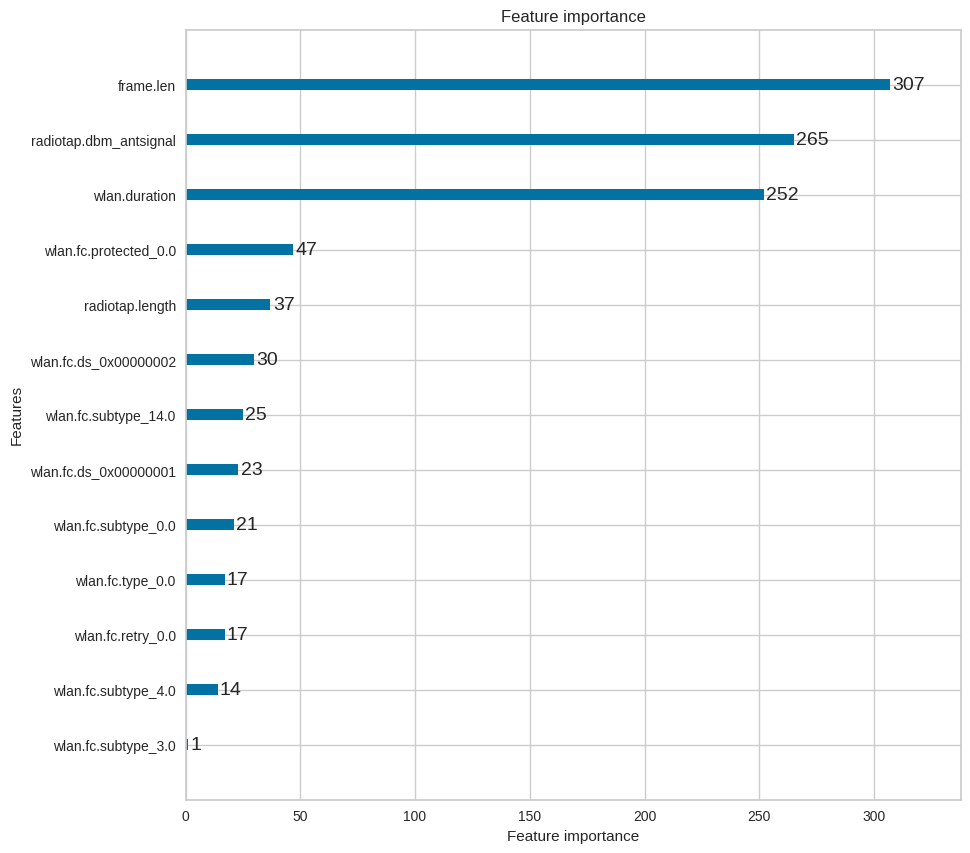

In [7]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    1.00000   0.99168   0.99582     24272
   Evil Twin    0.72740   1.00000   0.84219       539

    accuracy                        0.99186     24811
   macro avg    0.86370   0.99584   0.91900     24811
weighted avg    0.99408   0.99186   0.99248     24811


Confusion Matrix:

True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 0.00832


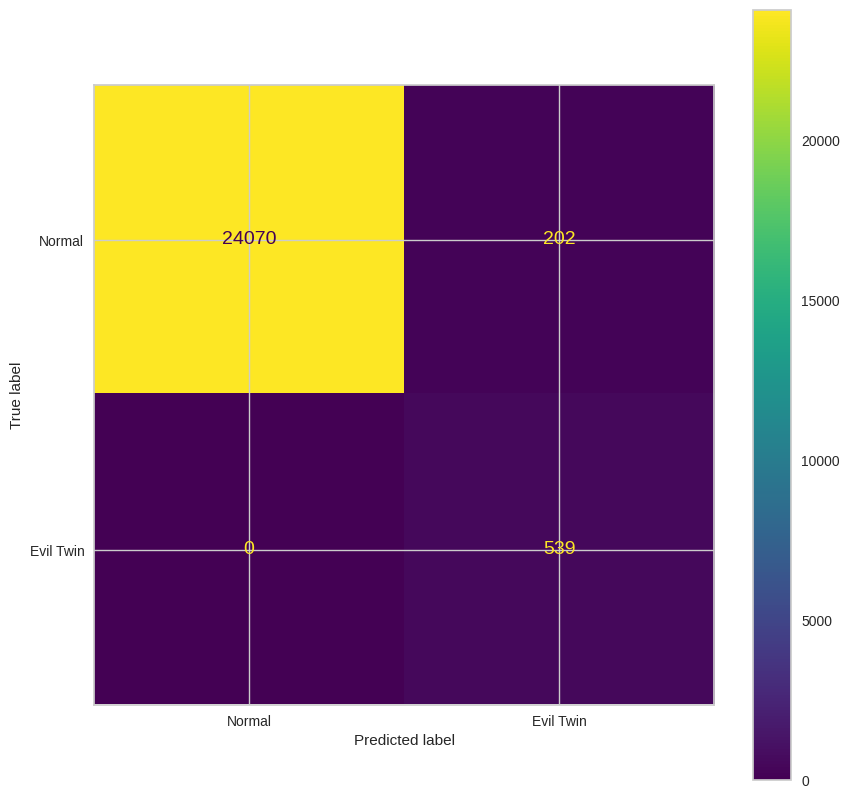

In [8]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test, y_test, ['Normal', 'Evil Twin'], None)

### Training and test with column set

In [9]:
# Numeric columns
numeric_columns = ['frame.len', 'radiotap.dbm_antsignal', 'wlan.duration']

* **Set 1** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.subtype*:

In [10]:
# Select column set (wlan.fc.subtype)
X_res_set_1 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.subtype')
X_test_set_1 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.subtype')

In [11]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_1, y_res, 10, 5, models_path, reports_path, 'set_1')

[LightGBM] [Warning] feature_fraction is set=0.8585343685805953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8585343685805953
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=1.4649591278344533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4649591278344533e-07
[LightGBM] [Warning] bagging_fraction is set=0.17975084311328676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17975084311328676
[LightGBM] [Warning] lambda_l1 is set=0.0054593546779896085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0054593546779896085
[LightGBM] [Warning] feature_fraction is set=0.8214463533415364, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8214463533415364
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=3.3358

[LightGBM] [Warning] feature_fraction is set=0.8585343685805953, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8585343685805953
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=1.4649591278344533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4649591278344533e-07
[LightGBM] [Warning] bagging_fraction is set=0.17975084311328676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17975084311328676
[LightGBM] [Warning] lambda_l1 is set=0.0054593546779896085, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0054593546779896085
[LightGBM] [Warning] feature_fraction is set=0.6539476693203553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6539476693203553
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=2.5578

[LightGBM] [Warning] feature_fraction is set=0.8010022038180787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8010022038180787
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.44111197207811825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.44111197207811825
[LightGBM] [Warning] bagging_fraction is set=0.46831388702764465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46831388702764465
[LightGBM] [Warning] lambda_l1 is set=2.4341119690540003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4341119690540003
[LightGBM] [Warning] feature_fraction is set=0.4271958358436496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4271958358436496
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=5.463070325326408e-0

[LightGBM] [Warning] feature_fraction is set=0.4271958358436496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4271958358436496
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=5.463070325326408e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.463070325326408e-06
[LightGBM] [Warning] bagging_fraction is set=0.1397228446298797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1397228446298797
[LightGBM] [Warning] lambda_l1 is set=0.009851309813297971, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009851309813297971
[LightGBM] [Warning] feature_fraction is set=0.7063306805893769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7063306805893769
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.405486085086

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

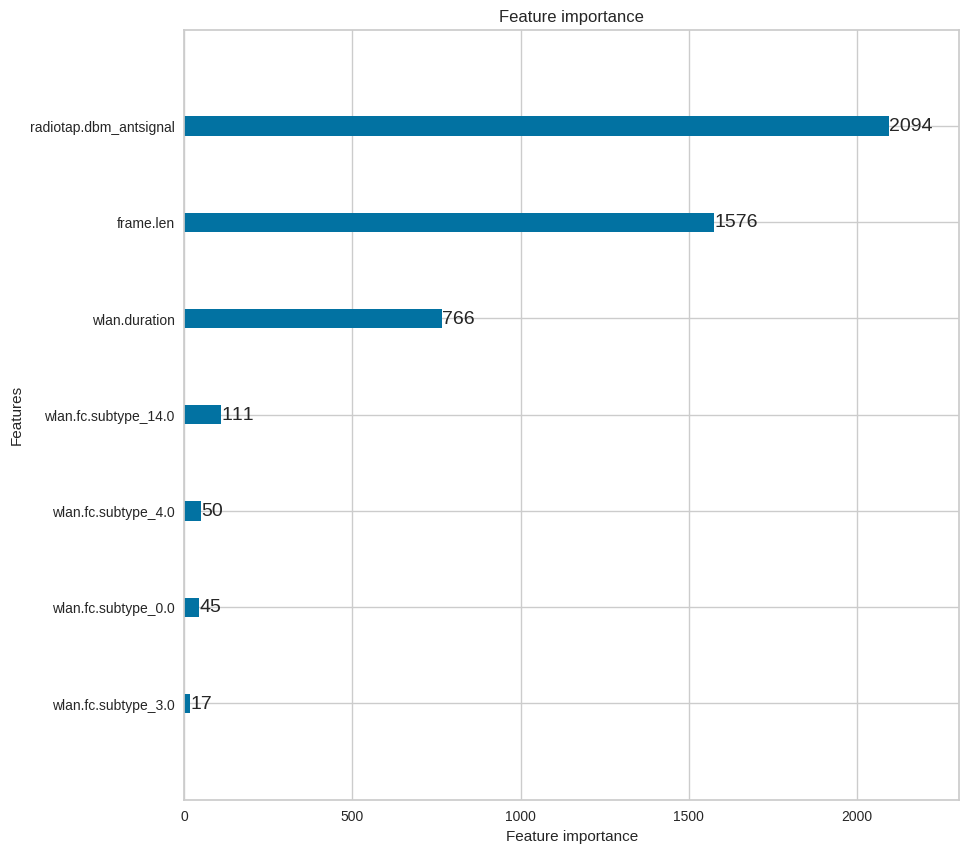

In [12]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99987   0.97483   0.98719     24272
   Evil Twin    0.46731   0.99443   0.63582       539

    accuracy                        0.97525     24811
   macro avg    0.73359   0.98463   0.81151     24811
weighted avg    0.98830   0.97525   0.97956     24811


Confusion Matrix:

True Positive Rate (TPR): 0.99443
False Positive Rate (FPR): 0.02517


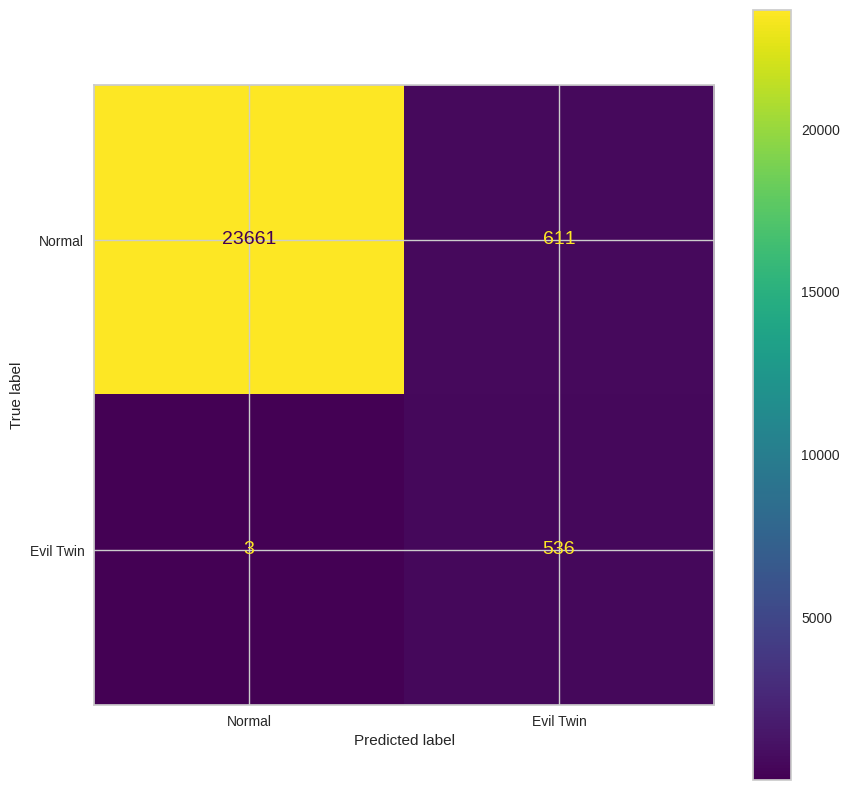

In [13]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_1, y_test, ['Normal', 'Evil Twin'], None)

* **Set 2** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.type*:

In [14]:
# Select column set (wlan.fc.type)
X_res_set_2 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.type')
X_test_set_2 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.type')

In [15]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_2, y_res, 10, 5, models_path, reports_path, 'set_2')

[LightGBM] [Warning] feature_fraction is set=0.29053643052168976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29053643052168976
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.14628539152305162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14628539152305162
[LightGBM] [Warning] bagging_fraction is set=0.2919904734128458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2919904734128458
[LightGBM] [Warning] lambda_l1 is set=4.5199518619632464e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5199518619632464e-07
[LightGBM] [Warning] feature_fraction is set=0.7426046374800241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7426046374800241
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.0106265508

[LightGBM] [Warning] feature_fraction is set=0.29053643052168976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29053643052168976
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.14628539152305162, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14628539152305162
[LightGBM] [Warning] bagging_fraction is set=0.2919904734128458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2919904734128458
[LightGBM] [Warning] lambda_l1 is set=4.5199518619632464e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5199518619632464e-07
[LightGBM] [Warning] feature_fraction is set=0.4702105701679341, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4702105701679341
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l2 is set=1.00009622

[LightGBM] [Warning] feature_fraction is set=0.4932732538063983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4932732538063983
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0.26126544640028876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.26126544640028876
[LightGBM] [Warning] bagging_fraction is set=0.9535035370634916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9535035370634916
[LightGBM] [Warning] lambda_l1 is set=1.718908947344339e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.718908947344339e-06
[LightGBM] [Warning] feature_fraction is set=0.4595738037975373, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4595738037975373
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.09792902022408

[LightGBM] [Warning] feature_fraction is set=0.9257670389646571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9257670389646571
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l2 is set=0.2568416794852609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2568416794852609
[LightGBM] [Warning] bagging_fraction is set=0.23133873124176046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.23133873124176046
[LightGBM] [Warning] lambda_l1 is set=6.673770985427827e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.673770985427827e-05
[LightGBM] [Warning] feature_fraction is set=0.851928128824337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.851928128824337
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] lambda_l2 is set=1.39772273430288

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

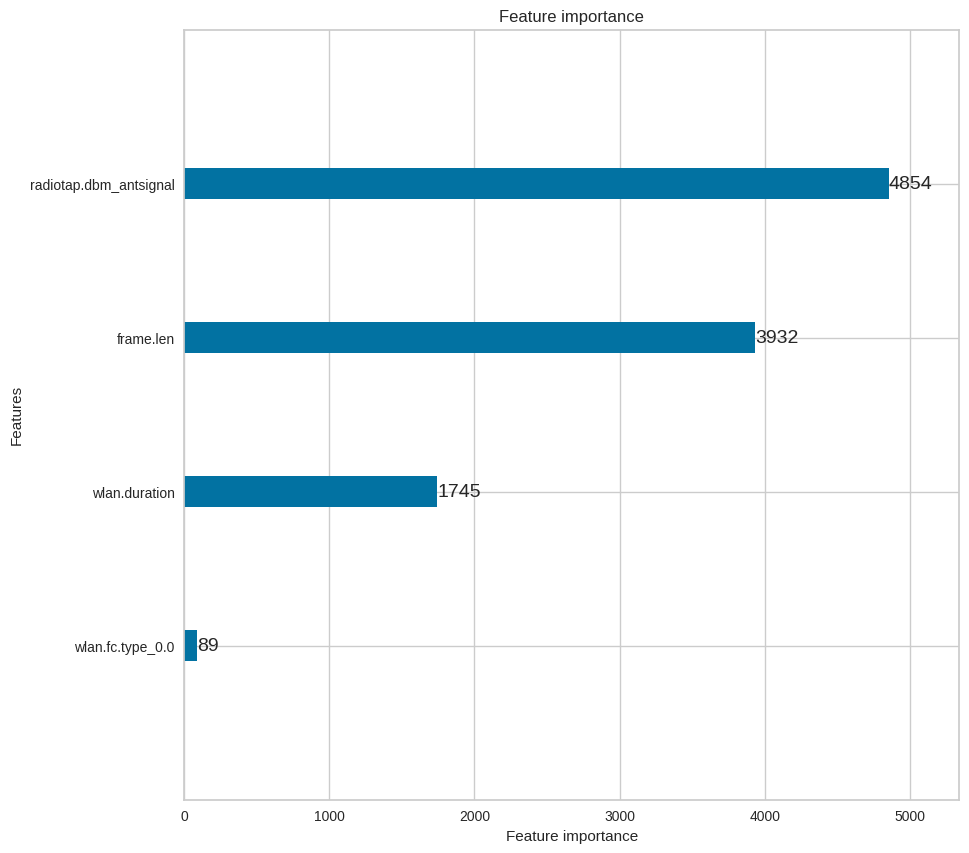

In [16]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99975   0.97763   0.98856     24272
   Evil Twin    0.49535   0.98887   0.66006       539

    accuracy                        0.97787     24811
   macro avg    0.74755   0.98325   0.82431     24811
weighted avg    0.98879   0.97787   0.98143     24811


Confusion Matrix:

True Positive Rate (TPR): 0.98887
False Positive Rate (FPR): 0.02237


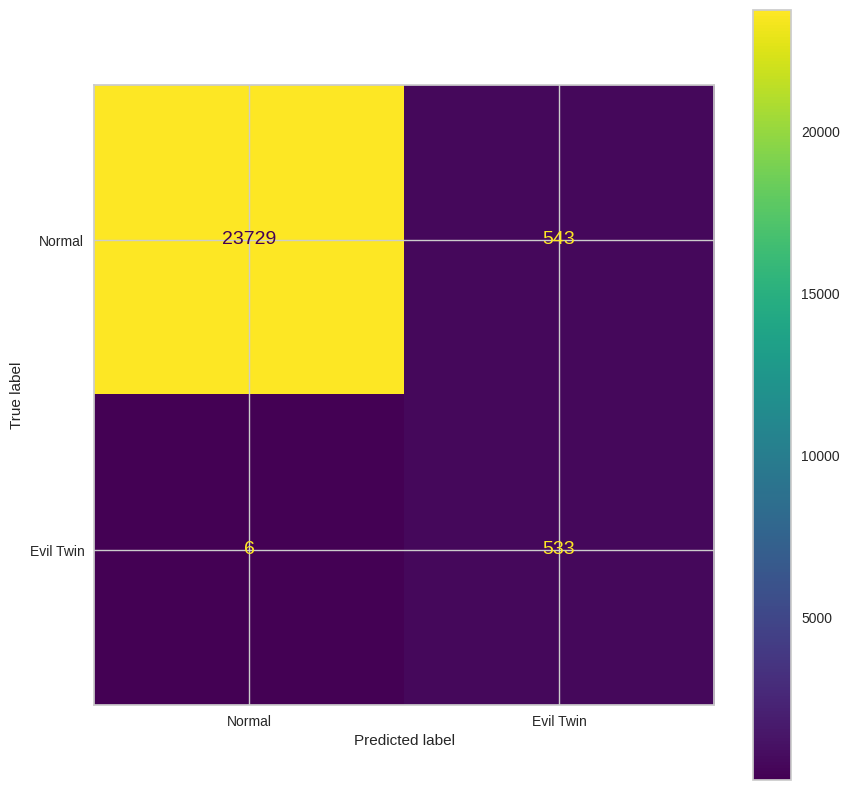

In [17]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_2, y_test, ['Normal', 'Evil Twin'], None)

* **Set 3** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.ds*

In [18]:
# Select column set (wlan.fc.ds)
X_res_set_3 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.ds')
X_test_set_3 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.ds')

In [19]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_3, y_res, 10, 5, models_path, reports_path, 'set_3')

[LightGBM] [Warning] feature_fraction is set=0.35050556247802167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35050556247802167
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=3.0693097446168534e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0693097446168534e-08
[LightGBM] [Warning] bagging_fraction is set=0.16508417509360396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16508417509360396
[LightGBM] [Warning] lambda_l1 is set=0.0030885512951032354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030885512951032354
[LightGBM] [Warning] feature_fraction is set=0.6342066973132392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6342066973132392
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=8.3457

[LightGBM] [Warning] feature_fraction is set=0.35050556247802167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35050556247802167
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] lambda_l2 is set=3.0693097446168534e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0693097446168534e-08
[LightGBM] [Warning] bagging_fraction is set=0.16508417509360396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.16508417509360396
[LightGBM] [Warning] lambda_l1 is set=0.0030885512951032354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030885512951032354
[LightGBM] [Warning] feature_fraction is set=0.14398333240396344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14398333240396344
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.16

[LightGBM] [Warning] feature_fraction is set=0.5556669779143257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5556669779143257
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l2 is set=3.848377449810983e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.848377449810983e-08
[LightGBM] [Warning] bagging_fraction is set=0.8833596300854976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8833596300854976
[LightGBM] [Warning] lambda_l1 is set=0.00728436546882173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00728436546882173
[LightGBM] [Warning] feature_fraction is set=0.9969277536423566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9969277536423566
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.027290170496

[LightGBM] [Warning] feature_fraction is set=0.738225300947518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.738225300947518
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] lambda_l2 is set=0.0001053824870595685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001053824870595685
[LightGBM] [Warning] bagging_fraction is set=0.2719452742568931, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2719452742568931
[LightGBM] [Warning] lambda_l1 is set=0.07885472911185253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07885472911185253
[LightGBM] [Warning] feature_fraction is set=0.9969277536423566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9969277536423566
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.02729017049630

[LightGBM] [Warning] feature_fraction is set=0.5556669779143257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5556669779143257
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
[LightGBM] [Warning] lambda_l2 is set=3.848377449810983e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.848377449810983e-08
[LightGBM] [Warning] bagging_fraction is set=0.8833596300854976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8833596300854976
[LightGBM] [Warning] lambda_l1 is set=0.00728436546882173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00728436546882173


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

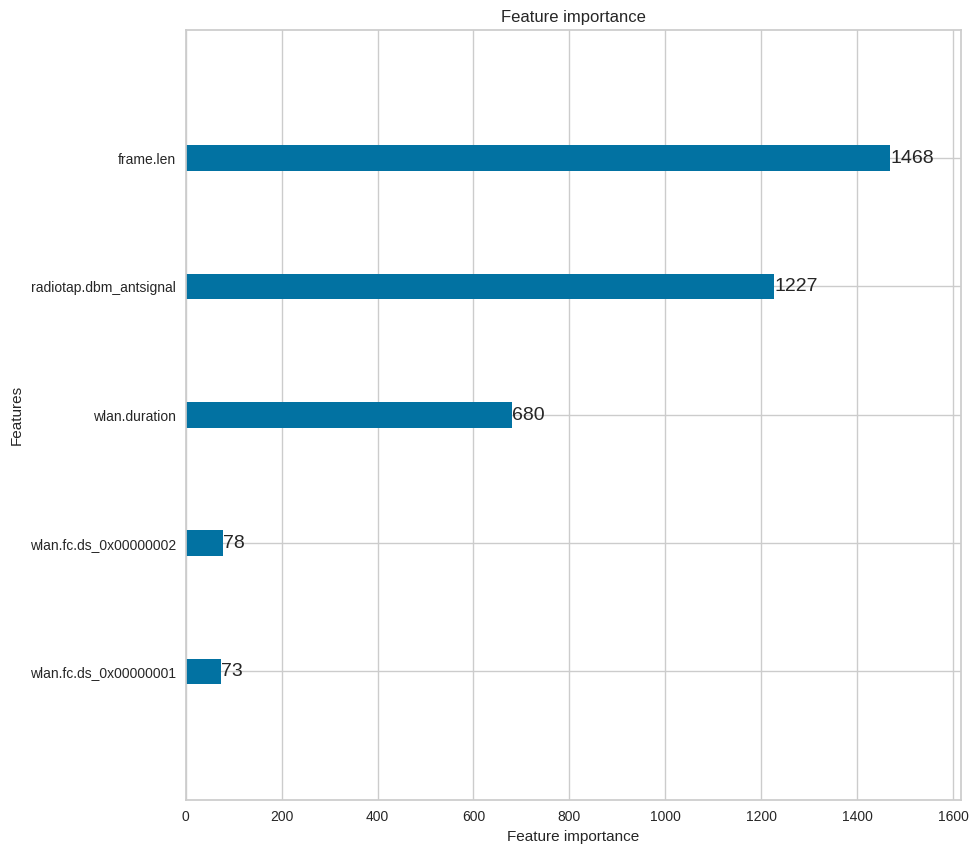

In [20]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    0.99983   0.97615   0.98785     24272
   Evil Twin    0.48025   0.99258   0.64731       539

    accuracy                        0.97650     24811
   macro avg    0.74004   0.98436   0.81758     24811
weighted avg    0.98854   0.97650   0.98045     24811


Confusion Matrix:

True Positive Rate (TPR): 0.99258
False Positive Rate (FPR): 0.02385


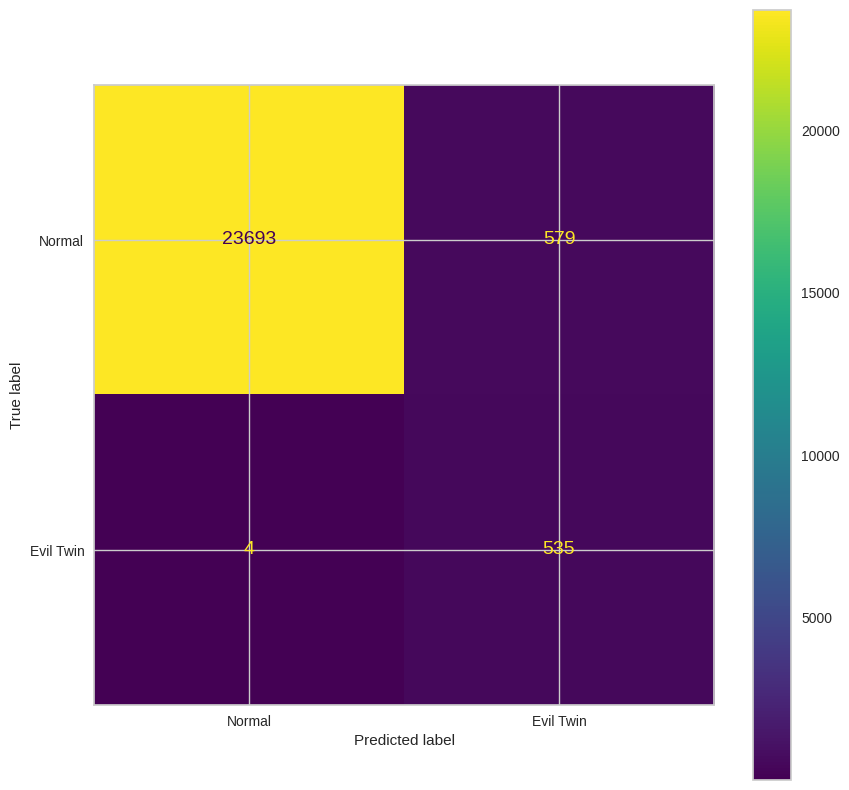

In [21]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_3, y_test, ['Normal', 'Evil Twin'], None)

* **Set 4** - frame.len, radiotap.dbm_antsignal, wlan.duration, and *wlan.fc.protected*

In [22]:
# Select column set (wlan.fc.protected)
X_res_set_4 = get_df_column_set(X_res, numeric_columns, 'wlan.fc.protected')
X_test_set_4 = get_df_column_set(X_test, numeric_columns, 'wlan.fc.protected')

In [23]:
%%capture
# Not plot show

# Optimize and save the model
model = optimize_save_lgb(X_res_set_4, y_res, 10, 5, models_path, reports_path, 'set_4')

[LightGBM] [Warning] feature_fraction is set=0.7423888898077943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7423888898077943
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=1.7782411335038014e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7782411335038014e-06
[LightGBM] [Warning] bagging_fraction is set=0.5773542365936498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5773542365936498
[LightGBM] [Warning] lambda_l1 is set=3.217270661113993e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.217270661113993e-07
[LightGBM] [Warning] feature_fraction is set=0.37422761693516615, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37422761693516615
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.032216

[LightGBM] [Warning] feature_fraction is set=0.1675951725737325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1675951725737325
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.004100233587556147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004100233587556147
[LightGBM] [Warning] bagging_fraction is set=0.5418485121805371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5418485121805371
[LightGBM] [Warning] lambda_l1 is set=7.412689340272794e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.412689340272794e-07
[LightGBM] [Warning] feature_fraction is set=0.7656274082352724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7656274082352724
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.1710748201

[LightGBM] [Warning] feature_fraction is set=0.24430125151339063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24430125151339063
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.8297187423802277e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8297187423802277e-07
[LightGBM] [Warning] bagging_fraction is set=0.5180047940260096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5180047940260096
[LightGBM] [Warning] lambda_l1 is set=0.117531502835711, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.117531502835711
[LightGBM] [Warning] feature_fraction is set=0.8296899204051321, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8296899204051321
[LightGBM] [Warning] bagging_freq is set=14, subsample_freq=0 will be ignored. Current value: bagging_freq=14
[LightGBM] [Warning] lambda_l2 is set=1.681598041277

[LightGBM] [Warning] feature_fraction is set=0.1675951725737325, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1675951725737325
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Current value: bagging_freq=13
[LightGBM] [Warning] lambda_l2 is set=0.004100233587556147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004100233587556147
[LightGBM] [Warning] bagging_fraction is set=0.5418485121805371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5418485121805371
[LightGBM] [Warning] lambda_l1 is set=7.412689340272794e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.412689340272794e-07
[LightGBM] [Warning] feature_fraction is set=0.1892150174493446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1892150174493446
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.0143592732

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

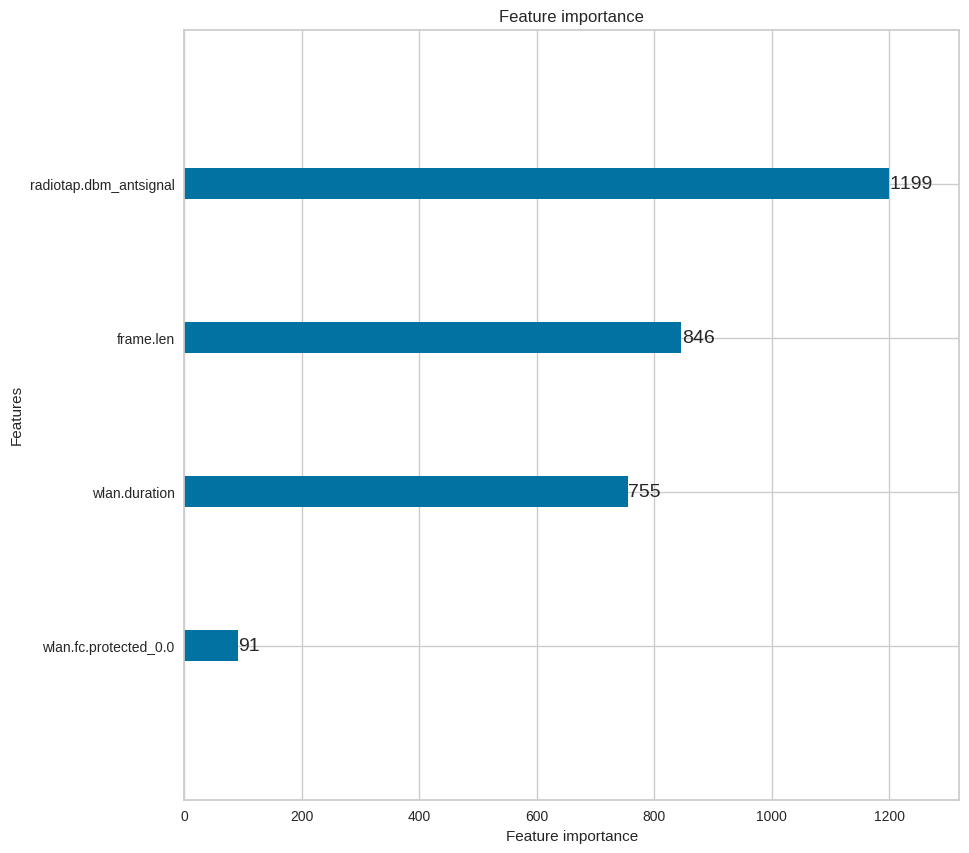

In [24]:
# Plot the importance of each feature on the trained model
lgb_plot_importance(model, (10, 10))

			Classification Report


              precision    recall  f1-score   support

      Normal    1.00000   0.99221   0.99609     24272
   Evil Twin    0.74038   1.00000   0.85083       539

    accuracy                        0.99238     24811
   macro avg    0.87019   0.99611   0.92346     24811
weighted avg    0.99436   0.99238   0.99294     24811


Confusion Matrix:

True Positive Rate (TPR): 1.0
False Positive Rate (FPR): 0.00779


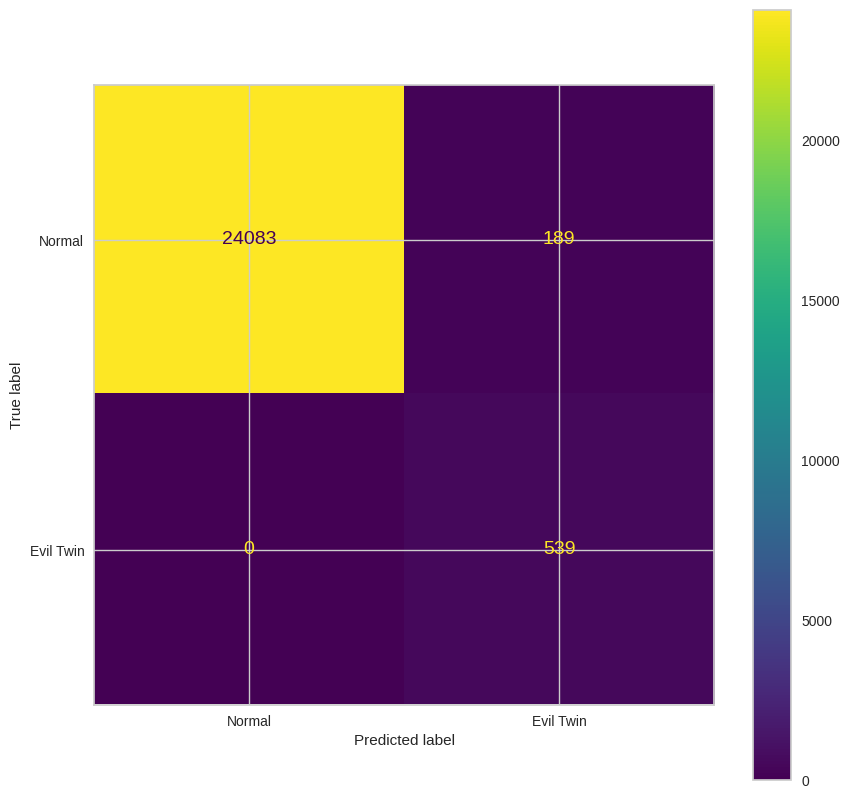

In [25]:
# LightGBM with optimized hyperparameters on test data
report_model(model, X_test_set_4, y_test, ['Normal', 'Evil Twin'], None)

### Using PyCaret for Automation

Only all columns only.

In [26]:
# Setting up PyCaret
setup = setup(data=train_df, target='Label', fold=5)

,Description,Value
0,Session id,8875
1,Target,Label
2,Target type,Binary
3,Original data shape,"(3147, 24)"
4,Transformed data shape,"(3147, 24)"
5,Transformed train set shape,"(2202, 24)"
6,Transformed test set shape,"(945, 24)"
7,Numeric features,23
8,Preprocess,True
9,Imputation type,simple


In [27]:
# Compare the different models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9927,0.9984,0.9977,0.9844,0.9910,0.9849,0.9850,0.1200
et,Extra Trees Classifier,0.9918,0.9976,0.9943,0.9855,0.9898,0.9830,0.9831,0.1080
gbc,Gradient Boosting Classifier,0.9914,0.9978,0.9989,0.9800,0.9893,0.9821,0.9822,0.0880
lightgbm,Light Gradient Boosting Machine,0.9914,0.9979,0.9966,0.9822,0.9893,0.9821,0.9822,0.0380
xgboost,Extreme Gradient Boosting,0.9909,0.9982,0.9932,0.9844,0.9887,0.9811,0.9812,0.0700
ada,Ada Boost Classifier,0.9896,0.9947,0.9943,0.9799,0.9870,0.9783,0.9784,0.0640
ridge,Ridge Classifier,0.9882,0.0000,0.9932,0.9777,0.9854,0.9755,0.9756,0.0160
lda,Linear Discriminant Analysis,0.9882,0.9919,0.9932,0.9777,0.9854,0.9755,0.9756,0.0200
svm,SVM - Linear Kernel,0.9877,0.0000,0.9898,0.9798,0.9847,0.9745,0.9746,0.0160
knn,K Neighbors Classifier,0.9873,0.9959,0.9966,0.9724,0.9843,0.9736,0.9739,0.1700


In [28]:
# Select one of the templates to generate
# Here 'lightgbm' will be used
creat_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9932,0.9981,1.0000,0.9833,0.9916,0.9859,0.9860
1,0.9887,0.9988,1.0000,0.9724,0.9860,0.9765,0.9767
2,0.9886,0.9993,0.9943,0.9777,0.9859,0.9764,0.9765
3,0.9955,0.9992,1.0000,0.9888,0.9944,0.9905,0.9906
4,0.9909,0.9943,0.9886,0.9886,0.9886,0.9811,0.9811
Mean,0.9914,0.9979,0.9966,0.9822,0.9893,0.9821,0.9822
Std,0.0026,0.0019,0.0045,0.0064,0.0033,0.0055,0.0054


In [29]:
# Evaluate the selected model
evaluate_model(creat_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [30]:
# Optimize the hyperparameters of the generated model
tuned = tune_model(creat_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9887,0.9989,0.9944,0.9778,0.9860,0.9765,0.9766
1,0.9864,0.9971,1.0000,0.9670,0.9832,0.9718,0.9722
2,0.9886,0.9991,1.0000,0.9724,0.9860,0.9764,0.9767
3,0.9886,0.9993,1.0000,0.9724,0.9860,0.9764,0.9767
4,0.9886,0.9958,0.9886,0.9831,0.9858,0.9763,0.9764
Mean,0.9882,0.9980,0.9966,0.9745,0.9854,0.9755,0.9757
Std,0.0009,0.0014,0.0045,0.0055,0.0011,0.0019,0.0018


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


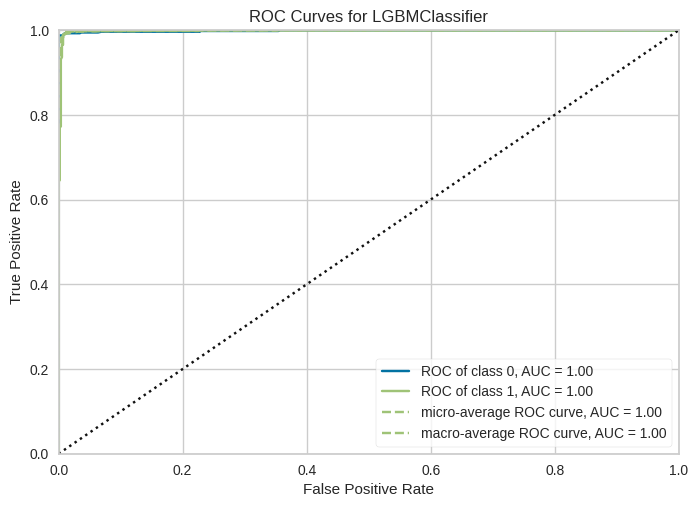

In [31]:
# ROC curve
plot_model(creat_model)

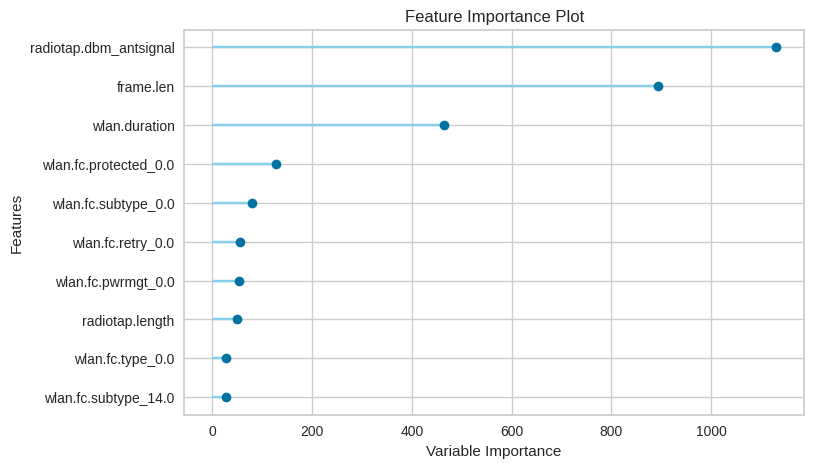

In [32]:
# Feature importance
plot_model(creat_model, plot='feature')

In [33]:
# Save the model
save_model(creat_model, f'{models_path}lightgbm_all_pycaret');

Transformation Pipeline and Model Successfully Saved


			Classification Report


              precision    recall  f1-score   support

      Normal    0.99988   0.99036   0.99509     24272
   Evil Twin    0.69610   0.99443   0.81895       539

    accuracy                        0.99045     24811
   macro avg    0.84799   0.99240   0.90702     24811
weighted avg    0.99328   0.99045   0.99127     24811


Confusion Matrix:

True Positive Rate (TPR): 0.99443
False Positive Rate (FPR): 0.00964


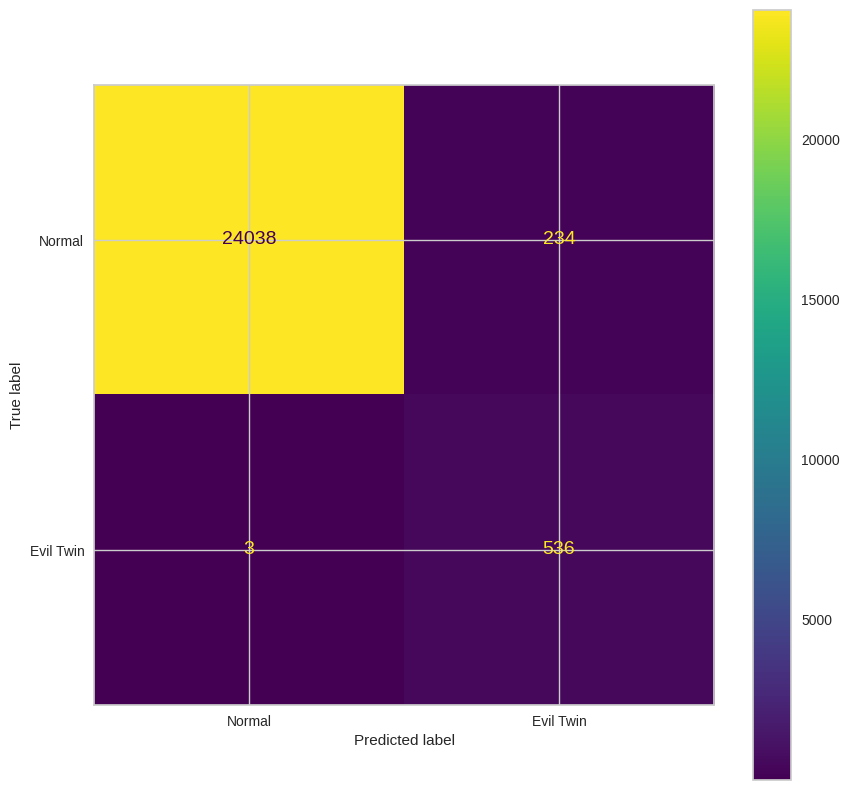

In [34]:
# LightGBM with optimized hyperparameters on test data
report_model(creat_model, X_test, y_test, ['Normal', 'Evil Twin'], None)